<a href="https://colab.research.google.com/github/Urara29/AE_face/blob/main/AE_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Conv2DTranspose, Activation, Flatten, Dropout, Reshape, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#カレントディレクトリに移動
%cd "/content/drive/My Drive/sotsuron/AE_face"

/content/drive/My Drive/sotsuron/AE_face


In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 7 not upgraded.
Need to get 95.1 MB of archives.
After this operation, 319 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 107.0.5304.87-0ubuntu11.18.04.1 [1,158 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 107.0.5304.87-0ubuntu11.1

In [ ]:
#パラメータ

#教師画像の親フォルダ
f = '/content/drive/MyDrive/sotsuron/AE_face/archive/train/all/'

#ミニバッチサイズ（教師データ数の公約数にしてください）
batch_size = 100

#乱数列の次元
z_dim = 100

#discriminatorの学習率
opt = keras.optimizers.Adam(learning_rate=0.0002)

#画像を保存するフォルダ
img_f = '/content/drive/MyDrive/sotsuron/AE_face/AE_img/'
#重みを保存するフォルダ
para_f = '/content/drive/MyDrive/sotsuron/AE_face/AE_para/'

In [ ]:
#教師データ読み込み
x_train = []
files = os.listdir(f)
for file in files:
    img = Image.open(f + file).convert("RGB"); img.close
    x_train.append(np.array(img))
x_train = np.array(x_train)

#-1～+1に規格化
x_train = (x_train - 127.5) / 127.5

#確認用に手前の10枚を隔離
x_test = []
f2 =  '/content/drive/MyDrive/sotsuron/AE_face/archive/test/test_dir/'
files2 = os.listdir(f2)
for file in files2:
    img = Image.open(f2 + file).convert("RGB"); img.close
    x_test.append(np.array(img))
x_test = np.array(x_test)
x_test = (x_test - 127.5) / 127.5
x_check = x_test

#入力と出力は同じですよ
y_train = x_train

print('枚数, たて, よこ, チャンネル')
print(x_train.shape)

枚数, たて, よこ, チャンネル
(1881, 48, 48, 3)


In [ ]:
#モデルの定義

def encoder_model():
    model = Sequential()
    
    #48*48*3ch → 24*24*16chにたたむ
    model.add(Conv2D(16, (4, 4), strides=(2, 2), padding='same', input_shape=(48, 48, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #24*24*16ch → 12*12*32chにたたむ
    model.add(Conv2D(32, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #12*12*32ch → 6*6*64chにたたむ
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #6*6*64ch → 3*3*128chにたたむ
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #フラットに伸ばして
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    #100次元まで圧縮
    model.add(Dense(z_dim))
    model.add(Activation('tanh'))
    
    return model

def decoder_model():
    model = Sequential()
    
    #100次元 → 3*3*128=1152次元に展開
    model.add(Dense(3*3*128, input_shape=(z_dim, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #3*3*128chに変形
    model.add(Reshape((3, 3, 128)))
    model.add(Dropout(0.5))
    
    #3*3*128ch → 6*6*64chにアップ
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #6*6*64ch → 12*12*32chにアップ
    model.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #12*12*32ch → 24*24*16chにアップ
    model.add(Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #24*24*16ch → 48*48*3chにアップ
    model.add(Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('tanh'))
    
    return model

def autoencoder_model(encoder, decoder):
    model = Sequential()
    model.add(encoder)
    model.add(decoder)
    return model

In [ ]:
#モデルの生成

#encoderの生成
encoder = encoder_model()
encoder.summary()
#decoderの生成
decoder = decoder_model()
decoder.summary()
#autoencoderの作成
autoencoder = autoencoder_model(encoder, decoder)
autoencoder.summary()

#autoencoderのコンパイル
autoencoder.compile(loss='msle', optimizer=opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        784       
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 24, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        8224      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 32)        0

In [ ]:
#保存用フォルダ作成
if not os.path.isdir(para_f): 
    os.makedirs(para_f)
if not os.path.isdir(img_f): 
    os.makedirs(img_f)

In [ ]:
#学習中のログ
#======================================
class EpisodeLogger(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        
        #一定epoch毎に画像表示
        if epoch % 50 == 0:
            #======================================
            x_ans = autoencoder.predict(x_check)

            stack1 = np.concatenate(x_check, axis=1)
            stack2 = np.concatenate(x_ans, axis=1)
            stack3 = np.concatenate([stack1, stack2], axis=0)
            img = Image.fromarray(np.uint8(stack3 * 127.5 + 127.5))

            plt.figure(figsize=(10, 10))
            img.save(img_f + str(epoch) + '.png')
            plt.imshow(img, vmin = 0, vmax = 255)
            plt.show()
            #======================================
        
        #一定epoch毎に重みを保存
        if epoch % 100 == 0:
            #重みの保存
            encoder.save(para_f + 'encoder_' + str(epoch) + '.h5')
            decoder.save(para_f + 'decoder_' + str(epoch) + '.h5')
#======================================

1/1 [==============================] - 1s 583ms/step


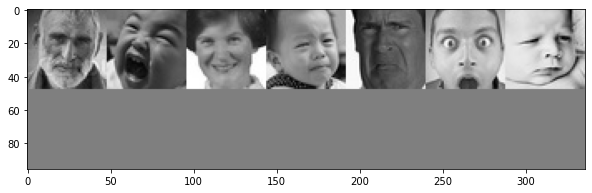

Epoch 1/3100
59/59 - 10s - loss: 0.0595 - 10s/epoch - 174ms/step
Epoch 2/3100
59/59 - 7s - loss: 0.0378 - 7s/epoch - 126ms/step
Epoch 3/3100
59/59 - 8s - loss: 0.0295 - 8s/epoch - 133ms/step
Epoch 4/3100
59/59 - 8s - loss: 0.0262 - 8s/epoch - 132ms/step
Epoch 5/3100
59/59 - 8s - loss: 0.0241 - 8s/epoch - 129ms/step
Epoch 6/3100
59/59 - 8s - loss: 0.0226 - 8s/epoch - 136ms/step
Epoch 7/3100
59/59 - 8s - loss: 0.0216 - 8s/epoch - 133ms/step
Epoch 8/3100
59/59 - 10s - loss: 0.0206 - 10s/epoch - 171ms/step
Epoch 9/3100
59/59 - 9s - loss: 0.0203 - 9s/epoch - 157ms/step
Epoch 10/3100
59/59 - 9s - loss: 0.0195 - 9s/epoch - 155ms/step
Epoch 11/3100
59/59 - 10s - loss: 0.0190 - 10s/epoch - 171ms/step
Epoch 12/3100
59/59 - 10s - loss: 0.0188 - 10s/epoch - 165ms/step
Epoch 13/3100
59/59 - 7s - loss: 0.0184 - 7s/epoch - 119ms/step
Epoch 14/3100
59/59 - 7s - loss: 0.0177 - 7s/epoch - 122ms/step
Epoch 15/3100
59/59 - 7s - loss: 0.0174 - 7s/epoch - 122ms/step
Epoch 16/3100
59/59 - 7s - loss: 0.0171 -

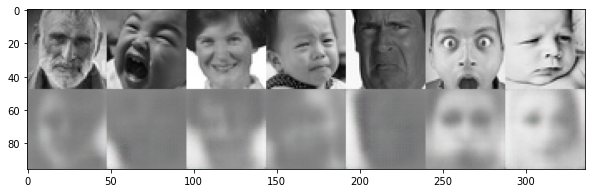

Epoch 51/3100
59/59 - 8s - loss: 0.0136 - 8s/epoch - 129ms/step
Epoch 52/3100
59/59 - 7s - loss: 0.0135 - 7s/epoch - 126ms/step
Epoch 53/3100
59/59 - 7s - loss: 0.0137 - 7s/epoch - 122ms/step
Epoch 54/3100
59/59 - 7s - loss: 0.0135 - 7s/epoch - 125ms/step
Epoch 55/3100
59/59 - 7s - loss: 0.0136 - 7s/epoch - 123ms/step
Epoch 56/3100
59/59 - 7s - loss: 0.0134 - 7s/epoch - 126ms/step
Epoch 57/3100
59/59 - 7s - loss: 0.0134 - 7s/epoch - 125ms/step
Epoch 58/3100
59/59 - 7s - loss: 0.0134 - 7s/epoch - 124ms/step
Epoch 59/3100
59/59 - 7s - loss: 0.0133 - 7s/epoch - 125ms/step
Epoch 60/3100
59/59 - 7s - loss: 0.0134 - 7s/epoch - 124ms/step
Epoch 61/3100
59/59 - 7s - loss: 0.0134 - 7s/epoch - 123ms/step
Epoch 62/3100
59/59 - 7s - loss: 0.0132 - 7s/epoch - 123ms/step
Epoch 63/3100
59/59 - 7s - loss: 0.0133 - 7s/epoch - 122ms/step
Epoch 64/3100
59/59 - 7s - loss: 0.0133 - 7s/epoch - 125ms/step
Epoch 65/3100
59/59 - 8s - loss: 0.0131 - 8s/epoch - 129ms/step
Epoch 66/3100
59/59 - 8s - loss: 0.0131 

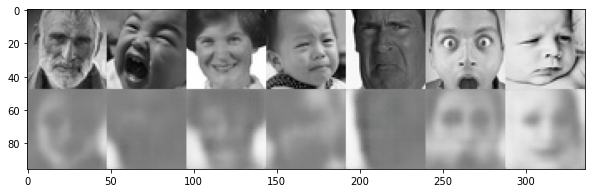

Epoch 101/3100
59/59 - 8s - loss: 0.0116 - 8s/epoch - 129ms/step
Epoch 102/3100
59/59 - 8s - loss: 0.0118 - 8s/epoch - 129ms/step
Epoch 103/3100
59/59 - 7s - loss: 0.0116 - 7s/epoch - 124ms/step
Epoch 104/3100
59/59 - 7s - loss: 0.0116 - 7s/epoch - 126ms/step
Epoch 105/3100
59/59 - 8s - loss: 0.0115 - 8s/epoch - 128ms/step
Epoch 106/3100
59/59 - 8s - loss: 0.0114 - 8s/epoch - 131ms/step
Epoch 107/3100
59/59 - 7s - loss: 0.0117 - 7s/epoch - 123ms/step
Epoch 108/3100
59/59 - 7s - loss: 0.0116 - 7s/epoch - 127ms/step
Epoch 109/3100
59/59 - 7s - loss: 0.0114 - 7s/epoch - 127ms/step
Epoch 110/3100
59/59 - 7s - loss: 0.0115 - 7s/epoch - 124ms/step
Epoch 111/3100
59/59 - 7s - loss: 0.0113 - 7s/epoch - 126ms/step
Epoch 112/3100
59/59 - 7s - loss: 0.0114 - 7s/epoch - 126ms/step
Epoch 113/3100
59/59 - 7s - loss: 0.0114 - 7s/epoch - 125ms/step
Epoch 114/3100
59/59 - 7s - loss: 0.0113 - 7s/epoch - 124ms/step
Epoch 115/3100
59/59 - 7s - loss: 0.0116 - 7s/epoch - 126ms/step
Epoch 116/3100
59/59 - 7s

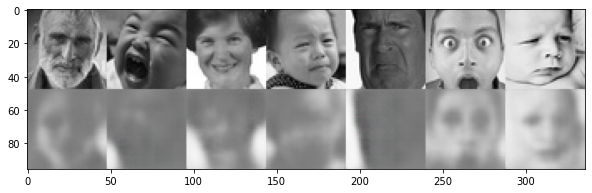

Epoch 151/3100
59/59 - 7s - loss: 0.0105 - 7s/epoch - 120ms/step
Epoch 152/3100
59/59 - 7s - loss: 0.0104 - 7s/epoch - 120ms/step
Epoch 153/3100
59/59 - 7s - loss: 0.0106 - 7s/epoch - 120ms/step
Epoch 154/3100
59/59 - 7s - loss: 0.0106 - 7s/epoch - 118ms/step
Epoch 155/3100
59/59 - 7s - loss: 0.0103 - 7s/epoch - 119ms/step
Epoch 156/3100
59/59 - 7s - loss: 0.0105 - 7s/epoch - 120ms/step
Epoch 157/3100
59/59 - 7s - loss: 0.0104 - 7s/epoch - 121ms/step
Epoch 158/3100
59/59 - 8s - loss: 0.0104 - 8s/epoch - 131ms/step
Epoch 159/3100
59/59 - 8s - loss: 0.0104 - 8s/epoch - 142ms/step
Epoch 160/3100
59/59 - 7s - loss: 0.0104 - 7s/epoch - 118ms/step
Epoch 161/3100
59/59 - 7s - loss: 0.0104 - 7s/epoch - 119ms/step
Epoch 162/3100
59/59 - 7s - loss: 0.0103 - 7s/epoch - 120ms/step
Epoch 163/3100
59/59 - 7s - loss: 0.0103 - 7s/epoch - 120ms/step
Epoch 164/3100
59/59 - 7s - loss: 0.0104 - 7s/epoch - 119ms/step
Epoch 165/3100
59/59 - 7s - loss: 0.0105 - 7s/epoch - 120ms/step
Epoch 166/3100
59/59 - 7s

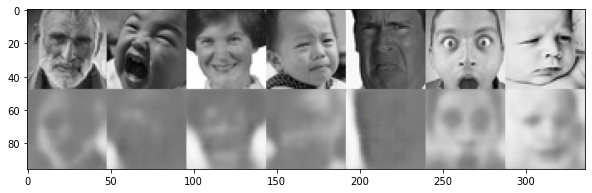

Epoch 201/3100
59/59 - 7s - loss: 0.0099 - 7s/epoch - 119ms/step
Epoch 202/3100
59/59 - 7s - loss: 0.0100 - 7s/epoch - 121ms/step
Epoch 203/3100
59/59 - 7s - loss: 0.0100 - 7s/epoch - 118ms/step
Epoch 204/3100
59/59 - 7s - loss: 0.0099 - 7s/epoch - 118ms/step
Epoch 205/3100
59/59 - 7s - loss: 0.0099 - 7s/epoch - 119ms/step
Epoch 206/3100
59/59 - 7s - loss: 0.0099 - 7s/epoch - 118ms/step
Epoch 207/3100
59/59 - 7s - loss: 0.0100 - 7s/epoch - 119ms/step
Epoch 208/3100
59/59 - 7s - loss: 0.0099 - 7s/epoch - 120ms/step
Epoch 209/3100
59/59 - 7s - loss: 0.0098 - 7s/epoch - 118ms/step
Epoch 210/3100
59/59 - 7s - loss: 0.0100 - 7s/epoch - 120ms/step
Epoch 211/3100
59/59 - 7s - loss: 0.0097 - 7s/epoch - 120ms/step
Epoch 212/3100
59/59 - 7s - loss: 0.0099 - 7s/epoch - 121ms/step
Epoch 213/3100
59/59 - 7s - loss: 0.0096 - 7s/epoch - 121ms/step
Epoch 214/3100
59/59 - 7s - loss: 0.0097 - 7s/epoch - 120ms/step
Epoch 215/3100
59/59 - 7s - loss: 0.0098 - 7s/epoch - 119ms/step
Epoch 216/3100
59/59 - 7s

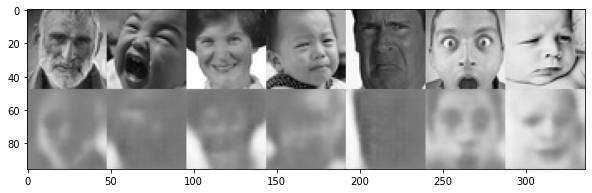

Epoch 251/3100
59/59 - 8s - loss: 0.0096 - 8s/epoch - 139ms/step
Epoch 252/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 122ms/step
Epoch 253/3100
59/59 - 7s - loss: 0.0095 - 7s/epoch - 122ms/step
Epoch 254/3100
59/59 - 7s - loss: 0.0095 - 7s/epoch - 122ms/step
Epoch 255/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 123ms/step
Epoch 256/3100
59/59 - 7s - loss: 0.0095 - 7s/epoch - 121ms/step
Epoch 257/3100
59/59 - 7s - loss: 0.0096 - 7s/epoch - 120ms/step
Epoch 258/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 123ms/step
Epoch 259/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 121ms/step
Epoch 260/3100
59/59 - 7s - loss: 0.0096 - 7s/epoch - 120ms/step
Epoch 261/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 121ms/step
Epoch 262/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 121ms/step
Epoch 263/3100
59/59 - 7s - loss: 0.0095 - 7s/epoch - 121ms/step
Epoch 264/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 121ms/step
Epoch 265/3100
59/59 - 7s - loss: 0.0094 - 7s/epoch - 121ms/step
Epoch 266/3100
59/59 - 7s

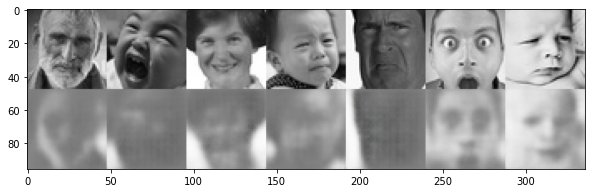

Epoch 301/3100
59/59 - 8s - loss: 0.0092 - 8s/epoch - 131ms/step
Epoch 302/3100
59/59 - 7s - loss: 0.0091 - 7s/epoch - 127ms/step
Epoch 303/3100
59/59 - 7s - loss: 0.0091 - 7s/epoch - 124ms/step
Epoch 304/3100
59/59 - 8s - loss: 0.0090 - 8s/epoch - 127ms/step
Epoch 305/3100
59/59 - 7s - loss: 0.0090 - 7s/epoch - 123ms/step
Epoch 306/3100
59/59 - 7s - loss: 0.0091 - 7s/epoch - 126ms/step
Epoch 307/3100
59/59 - 7s - loss: 0.0091 - 7s/epoch - 122ms/step
Epoch 308/3100
59/59 - 7s - loss: 0.0091 - 7s/epoch - 127ms/step
Epoch 309/3100
59/59 - 8s - loss: 0.0090 - 8s/epoch - 129ms/step
Epoch 310/3100
59/59 - 10s - loss: 0.0090 - 10s/epoch - 162ms/step
Epoch 311/3100
59/59 - 8s - loss: 0.0090 - 8s/epoch - 131ms/step
Epoch 312/3100
59/59 - 8s - loss: 0.0090 - 8s/epoch - 130ms/step
Epoch 313/3100
59/59 - 8s - loss: 0.0091 - 8s/epoch - 129ms/step
Epoch 314/3100
59/59 - 8s - loss: 0.0090 - 8s/epoch - 130ms/step
Epoch 315/3100
59/59 - 8s - loss: 0.0091 - 8s/epoch - 130ms/step
Epoch 316/3100
59/59 - 

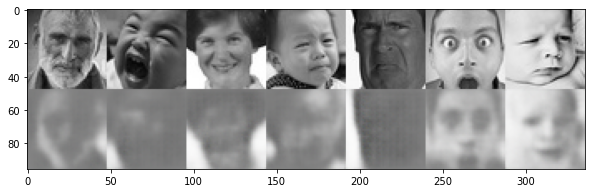

Epoch 351/3100
59/59 - 8s - loss: 0.0089 - 8s/epoch - 129ms/step
Epoch 352/3100
59/59 - 7s - loss: 0.0090 - 7s/epoch - 124ms/step
Epoch 353/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 122ms/step
Epoch 354/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 124ms/step
Epoch 355/3100
59/59 - 7s - loss: 0.0090 - 7s/epoch - 124ms/step
Epoch 356/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 124ms/step
Epoch 357/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 126ms/step
Epoch 358/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 127ms/step
Epoch 359/3100
59/59 - 7s - loss: 0.0090 - 7s/epoch - 126ms/step
Epoch 360/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 125ms/step
Epoch 361/3100
59/59 - 8s - loss: 0.0089 - 8s/epoch - 129ms/step
Epoch 362/3100
59/59 - 7s - loss: 0.0088 - 7s/epoch - 125ms/step
Epoch 363/3100
59/59 - 8s - loss: 0.0089 - 8s/epoch - 130ms/step
Epoch 364/3100
59/59 - 7s - loss: 0.0089 - 7s/epoch - 126ms/step
Epoch 365/3100
59/59 - 7s - loss: 0.0088 - 7s/epoch - 124ms/step
Epoch 366/3100
59/59 - 7s

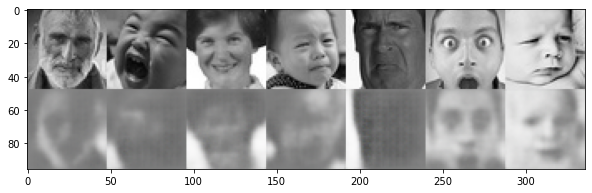

Epoch 401/3100
59/59 - 8s - loss: 0.0089 - 8s/epoch - 139ms/step
Epoch 402/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 136ms/step
Epoch 403/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 129ms/step
Epoch 404/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 135ms/step
Epoch 405/3100
59/59 - 8s - loss: 0.0088 - 8s/epoch - 137ms/step
Epoch 406/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 140ms/step
Epoch 407/3100
59/59 - 8s - loss: 0.0088 - 8s/epoch - 129ms/step
Epoch 408/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 130ms/step
Epoch 409/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 128ms/step
Epoch 410/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 134ms/step
Epoch 411/3100
59/59 - 8s - loss: 0.0088 - 8s/epoch - 129ms/step
Epoch 412/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 134ms/step
Epoch 413/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 137ms/step
Epoch 414/3100
59/59 - 8s - loss: 0.0088 - 8s/epoch - 131ms/step
Epoch 415/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 131ms/step
Epoch 416/3100
59/59 - 8s

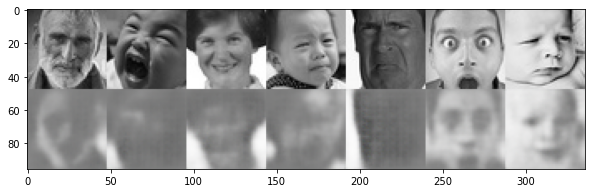

Epoch 451/3100
59/59 - 8s - loss: 0.0087 - 8s/epoch - 133ms/step
Epoch 452/3100
59/59 - 8s - loss: 0.0086 - 8s/epoch - 131ms/step
Epoch 453/3100
59/59 - 8s - loss: 0.0086 - 8s/epoch - 128ms/step
Epoch 454/3100
59/59 - 9s - loss: 0.0087 - 9s/epoch - 156ms/step
Epoch 455/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 124ms/step
Epoch 456/3100
59/59 - 7s - loss: 0.0085 - 7s/epoch - 125ms/step
Epoch 457/3100
59/59 - 7s - loss: 0.0087 - 7s/epoch - 124ms/step
Epoch 458/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 125ms/step
Epoch 459/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 124ms/step
Epoch 460/3100
59/59 - 7s - loss: 0.0087 - 7s/epoch - 125ms/step
Epoch 461/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 123ms/step
Epoch 462/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 124ms/step
Epoch 463/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 125ms/step
Epoch 464/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 124ms/step
Epoch 465/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 127ms/step
Epoch 466/3100
59/59 - 7s

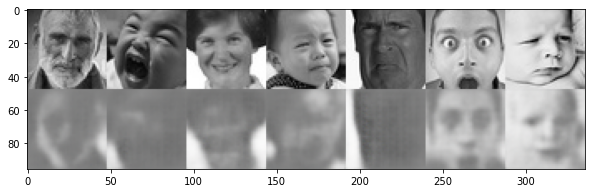

Epoch 501/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 126ms/step
Epoch 502/3100
59/59 - 8s - loss: 0.0086 - 8s/epoch - 136ms/step
Epoch 503/3100
59/59 - 8s - loss: 0.0086 - 8s/epoch - 132ms/step
Epoch 504/3100
59/59 - 7s - loss: 0.0085 - 7s/epoch - 127ms/step
Epoch 505/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 128ms/step
Epoch 506/3100
59/59 - 8s - loss: 0.0086 - 8s/epoch - 128ms/step
Epoch 507/3100
59/59 - 7s - loss: 0.0086 - 7s/epoch - 127ms/step
Epoch 508/3100
59/59 - 7s - loss: 0.0085 - 7s/epoch - 126ms/step
Epoch 509/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 128ms/step
Epoch 510/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 128ms/step
Epoch 511/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 131ms/step
Epoch 512/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 129ms/step
Epoch 513/3100
59/59 - 9s - loss: 0.0084 - 9s/epoch - 159ms/step
Epoch 514/3100
59/59 - 7s - loss: 0.0085 - 7s/epoch - 126ms/step
Epoch 515/3100
59/59 - 7s - loss: 0.0085 - 7s/epoch - 127ms/step
Epoch 516/3100
59/59 - 7s

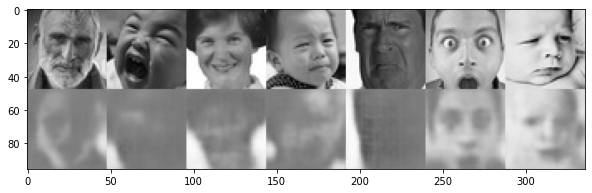

Epoch 551/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 132ms/step
Epoch 552/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 136ms/step
Epoch 553/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 133ms/step
Epoch 554/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 134ms/step
Epoch 555/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 136ms/step
Epoch 556/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 139ms/step
Epoch 557/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 138ms/step
Epoch 558/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 139ms/step
Epoch 559/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 134ms/step
Epoch 560/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 138ms/step
Epoch 561/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 141ms/step
Epoch 562/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 138ms/step
Epoch 563/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 140ms/step
Epoch 564/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 140ms/step
Epoch 565/3100
59/59 - 8s - loss: 0.0085 - 8s/epoch - 143ms/step
Epoch 566/3100
59/59 - 8s

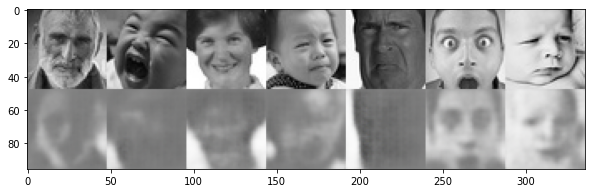

Epoch 601/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 141ms/step
Epoch 602/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 139ms/step
Epoch 603/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 139ms/step
Epoch 604/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 136ms/step
Epoch 605/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 132ms/step
Epoch 606/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 138ms/step
Epoch 607/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 132ms/step
Epoch 608/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 132ms/step
Epoch 609/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 136ms/step
Epoch 610/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 135ms/step
Epoch 611/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 136ms/step
Epoch 612/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 132ms/step
Epoch 613/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 130ms/step
Epoch 614/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 129ms/step
Epoch 615/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 132ms/step
Epoch 616/3100
59/59 - 8s

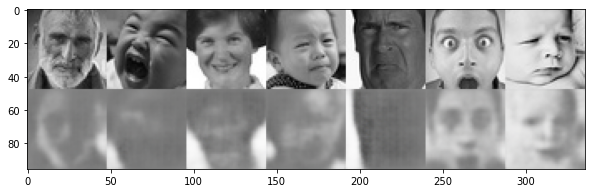

Epoch 651/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 143ms/step
Epoch 652/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 140ms/step
Epoch 653/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 135ms/step
Epoch 654/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 132ms/step
Epoch 655/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 133ms/step
Epoch 656/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 136ms/step
Epoch 657/3100
59/59 - 10s - loss: 0.0084 - 10s/epoch - 165ms/step
Epoch 658/3100
59/59 - 8s - loss: 0.0084 - 8s/epoch - 133ms/step
Epoch 659/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 129ms/step
Epoch 660/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 129ms/step
Epoch 661/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 131ms/step
Epoch 662/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 130ms/step
Epoch 663/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 133ms/step
Epoch 664/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 136ms/step
Epoch 665/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 133ms/step
Epoch 666/3100
59/59 - 

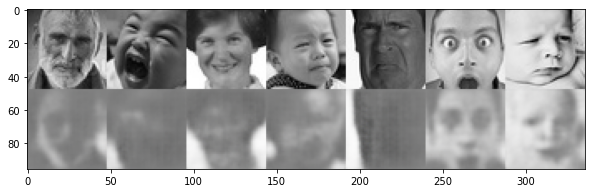

Epoch 701/3100
59/59 - 7s - loss: 0.0082 - 7s/epoch - 125ms/step
Epoch 702/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 128ms/step
Epoch 703/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 127ms/step
Epoch 704/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 130ms/step
Epoch 705/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 130ms/step
Epoch 706/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 130ms/step
Epoch 707/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 130ms/step
Epoch 708/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 134ms/step
Epoch 709/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 710/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 132ms/step
Epoch 711/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 130ms/step
Epoch 712/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 713/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 135ms/step
Epoch 714/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 131ms/step
Epoch 715/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 127ms/step
Epoch 716/3100
59/59 - 8s

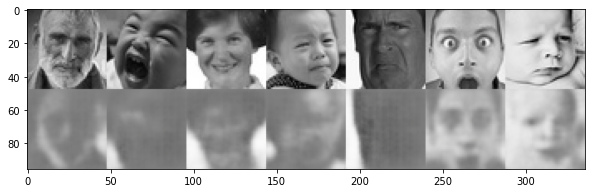

Epoch 751/3100
59/59 - 8s - loss: 0.0083 - 8s/epoch - 136ms/step
Epoch 752/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 139ms/step
Epoch 753/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 135ms/step
Epoch 754/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 140ms/step
Epoch 755/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 132ms/step
Epoch 756/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 757/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 758/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 130ms/step
Epoch 759/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 760/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 131ms/step
Epoch 761/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 130ms/step
Epoch 762/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 135ms/step
Epoch 763/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 764/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 130ms/step
Epoch 765/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 128ms/step
Epoch 766/3100
59/59 - 8s

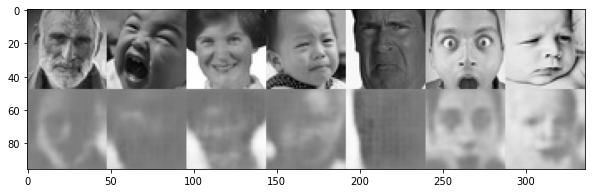

Epoch 801/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 129ms/step
Epoch 802/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 131ms/step
Epoch 803/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 133ms/step
Epoch 804/3100
59/59 - 9s - loss: 0.0081 - 9s/epoch - 148ms/step
Epoch 805/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 143ms/step
Epoch 806/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 131ms/step
Epoch 807/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 130ms/step
Epoch 808/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 133ms/step
Epoch 809/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 128ms/step
Epoch 810/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 132ms/step
Epoch 811/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 134ms/step
Epoch 812/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 131ms/step
Epoch 813/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 134ms/step
Epoch 814/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 128ms/step
Epoch 815/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 128ms/step
Epoch 816/3100
59/59 - 8s

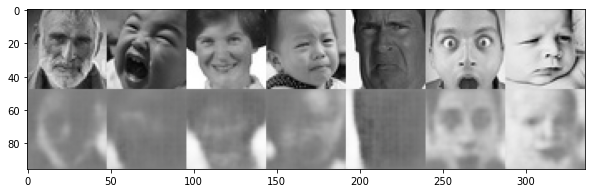

Epoch 851/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 137ms/step
Epoch 852/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 140ms/step
Epoch 853/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 140ms/step
Epoch 854/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 139ms/step
Epoch 855/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 138ms/step
Epoch 856/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 143ms/step
Epoch 857/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 139ms/step
Epoch 858/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 139ms/step
Epoch 859/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 139ms/step
Epoch 860/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 139ms/step
Epoch 861/3100
59/59 - 7s - loss: 0.0081 - 7s/epoch - 125ms/step
Epoch 862/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 134ms/step
Epoch 863/3100
59/59 - 10s - loss: 0.0081 - 10s/epoch - 170ms/step
Epoch 864/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 134ms/step
Epoch 865/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 139ms/step
Epoch 866/3100
59/59 - 

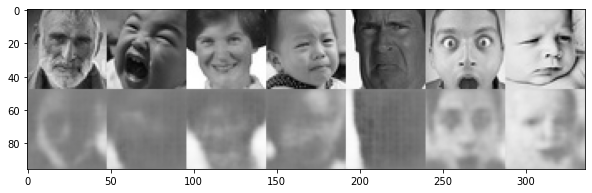

Epoch 901/3100
59/59 - 8s - loss: 0.0082 - 8s/epoch - 130ms/step
Epoch 902/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 128ms/step
Epoch 903/3100
59/59 - 7s - loss: 0.0081 - 7s/epoch - 127ms/step
Epoch 904/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 128ms/step
Epoch 905/3100
59/59 - 7s - loss: 0.0082 - 7s/epoch - 127ms/step
Epoch 906/3100
59/59 - 7s - loss: 0.0081 - 7s/epoch - 127ms/step
Epoch 907/3100
59/59 - 7s - loss: 0.0080 - 7s/epoch - 127ms/step
Epoch 908/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 129ms/step
Epoch 909/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 128ms/step
Epoch 910/3100
59/59 - 7s - loss: 0.0080 - 7s/epoch - 127ms/step
Epoch 911/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 128ms/step
Epoch 912/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 127ms/step
Epoch 913/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 127ms/step
Epoch 914/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 129ms/step
Epoch 915/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 129ms/step
Epoch 916/3100
59/59 - 8s

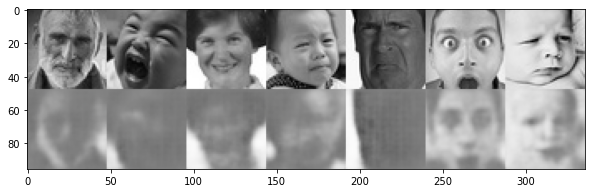

Epoch 951/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 136ms/step
Epoch 952/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 131ms/step
Epoch 953/3100
59/59 - 9s - loss: 0.0080 - 9s/epoch - 150ms/step
Epoch 954/3100
59/59 - 9s - loss: 0.0080 - 9s/epoch - 146ms/step
Epoch 955/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 132ms/step
Epoch 956/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 133ms/step
Epoch 957/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 133ms/step
Epoch 958/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 128ms/step
Epoch 959/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 132ms/step
Epoch 960/3100
59/59 - 7s - loss: 0.0081 - 7s/epoch - 127ms/step
Epoch 961/3100
59/59 - 8s - loss: 0.0081 - 8s/epoch - 132ms/step
Epoch 962/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 134ms/step
Epoch 963/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 132ms/step
Epoch 964/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 131ms/step
Epoch 965/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 133ms/step
Epoch 966/3100
59/59 - 8s

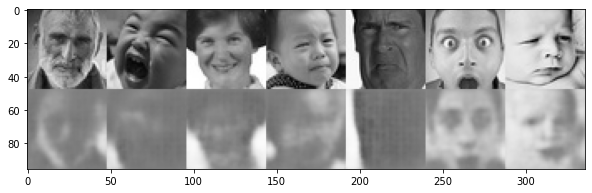

Epoch 1001/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 129ms/step
Epoch 1002/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 132ms/step
Epoch 1003/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 130ms/step
Epoch 1004/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 131ms/step
Epoch 1005/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 133ms/step
Epoch 1006/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 133ms/step
Epoch 1007/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 130ms/step
Epoch 1008/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 132ms/step
Epoch 1009/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 131ms/step
Epoch 1010/3100
59/59 - 7s - loss: 0.0080 - 7s/epoch - 127ms/step
Epoch 1011/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 130ms/step
Epoch 1012/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 132ms/step
Epoch 1013/3100
59/59 - 10s - loss: 0.0080 - 10s/epoch - 162ms/step
Epoch 1014/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 131ms/step
Epoch 1015/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 130ms/step
Epoch 10

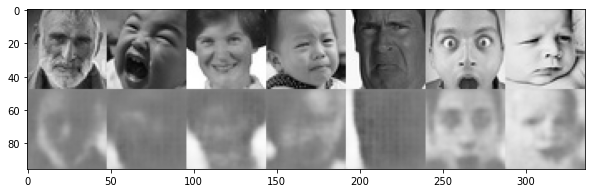

Epoch 1051/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1052/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1053/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 137ms/step
Epoch 1054/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 141ms/step
Epoch 1055/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1056/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 140ms/step
Epoch 1057/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 140ms/step
Epoch 1058/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1059/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 130ms/step
Epoch 1060/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 134ms/step
Epoch 1061/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 136ms/step
Epoch 1062/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 134ms/step
Epoch 1063/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 136ms/step
Epoch 1064/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 128ms/step
Epoch 1065/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 135ms/step
Epoch 1066

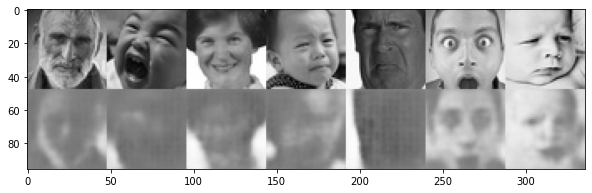

Epoch 1101/3100
59/59 - 10s - loss: 0.0079 - 10s/epoch - 166ms/step
Epoch 1102/3100
59/59 - 9s - loss: 0.0080 - 9s/epoch - 152ms/step
Epoch 1103/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 140ms/step
Epoch 1104/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 142ms/step
Epoch 1105/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 141ms/step
Epoch 1106/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 142ms/step
Epoch 1107/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1108/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 142ms/step
Epoch 1109/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1110/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 139ms/step
Epoch 1111/3100
59/59 - 9s - loss: 0.0079 - 9s/epoch - 145ms/step
Epoch 1112/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 133ms/step
Epoch 1113/3100
59/59 - 8s - loss: 0.0080 - 8s/epoch - 137ms/step
Epoch 1114/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1115/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 136ms/step
Epoch 11

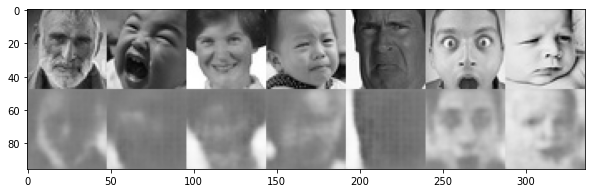

Epoch 1151/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 141ms/step
Epoch 1152/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 142ms/step
Epoch 1153/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 140ms/step
Epoch 1154/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 142ms/step
Epoch 1155/3100
59/59 - 9s - loss: 0.0079 - 9s/epoch - 147ms/step
Epoch 1156/3100
59/59 - 9s - loss: 0.0079 - 9s/epoch - 144ms/step
Epoch 1157/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 143ms/step
Epoch 1158/3100
59/59 - 10s - loss: 0.0079 - 10s/epoch - 174ms/step
Epoch 1159/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 143ms/step
Epoch 1160/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 143ms/step
Epoch 1161/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 139ms/step
Epoch 1162/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1163/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1164/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1165/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 136ms/step
Epoch 11

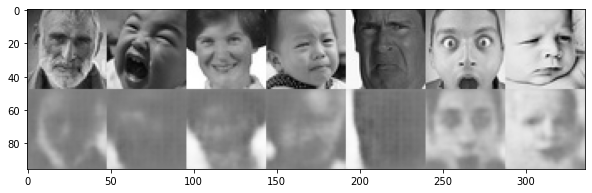

Epoch 1201/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1202/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 142ms/step
Epoch 1203/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 138ms/step
Epoch 1204/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1205/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 134ms/step
Epoch 1206/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 140ms/step
Epoch 1207/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 141ms/step
Epoch 1208/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 139ms/step
Epoch 1209/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1210/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 134ms/step
Epoch 1211/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 134ms/step
Epoch 1212/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 133ms/step
Epoch 1213/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 134ms/step
Epoch 1214/3100
59/59 - 10s - loss: 0.0078 - 10s/epoch - 167ms/step
Epoch 1215/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 135ms/step
Epoch 12

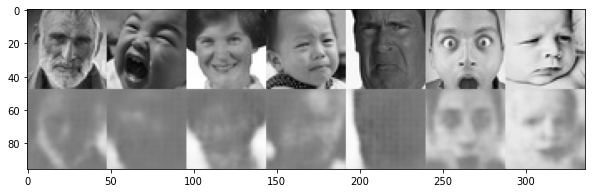

Epoch 1251/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 137ms/step
Epoch 1252/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 140ms/step
Epoch 1253/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 138ms/step
Epoch 1254/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 139ms/step
Epoch 1255/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 139ms/step
Epoch 1256/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 143ms/step
Epoch 1257/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 136ms/step
Epoch 1258/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 143ms/step
Epoch 1259/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 139ms/step
Epoch 1260/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 140ms/step
Epoch 1261/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 141ms/step
Epoch 1262/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 140ms/step
Epoch 1263/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 144ms/step
Epoch 1264/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 143ms/step
Epoch 1265/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 142ms/step
Epoch 1266

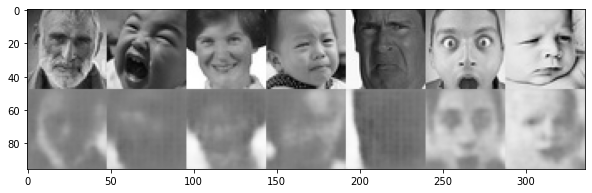

Epoch 1301/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 138ms/step
Epoch 1302/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 131ms/step
Epoch 1303/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 135ms/step
Epoch 1304/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 134ms/step
Epoch 1305/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 137ms/step
Epoch 1306/3100
59/59 - 9s - loss: 0.0078 - 9s/epoch - 144ms/step
Epoch 1307/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 139ms/step
Epoch 1308/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 141ms/step
Epoch 1309/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 140ms/step
Epoch 1310/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 136ms/step
Epoch 1311/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 140ms/step
Epoch 1312/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 138ms/step
Epoch 1313/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 140ms/step
Epoch 1314/3100
59/59 - 8s - loss: 0.0077 - 8s/epoch - 140ms/step
Epoch 1315/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 137ms/step
Epoch 1316

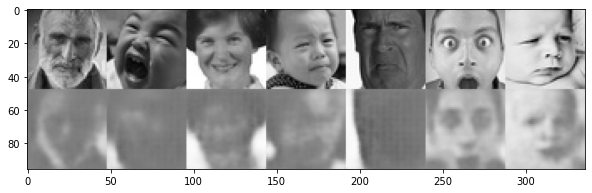

Epoch 1351/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 142ms/step
Epoch 1352/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 135ms/step
Epoch 1353/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 143ms/step
Epoch 1354/3100
59/59 - 8s - loss: 0.0079 - 8s/epoch - 142ms/step
Epoch 1355/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 137ms/step
Epoch 1356/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 144ms/step
Epoch 1357/3100
59/59 - 10s - loss: 0.0078 - 10s/epoch - 166ms/step
Epoch 1358/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 143ms/step
Epoch 1359/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 139ms/step
Epoch 1360/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 139ms/step
Epoch 1361/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 136ms/step
Epoch 1362/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 135ms/step
Epoch 1363/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 134ms/step
Epoch 1364/3100
59/59 - 8s - loss: 0.0077 - 8s/epoch - 137ms/step
Epoch 1365/3100
59/59 - 8s - loss: 0.0078 - 8s/epoch - 135ms/step
Epoch 13

KeyboardInterrupt: ignored

In [ ]:
#学習
hist = autoencoder.fit(x_train, y_train, epochs=3100, batch_size=batch_size, verbose=2, callbacks=[EpisodeLogger()])